# Combinatorial library properties

## Aim of this notebook

In this notebook we want to analyze properties of the combinatorial library, such as the ligand size and Lipinski's rule of five criteria.

## Table of contents

1. Combinatorial library data
2. Recombined ligand size
3. Lipinski's rule of five

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import ijson
import matplotlib.pyplot as plt
import pandas as pd
from rdkit import Chem

from utils import get_original_ligands, get_ro5_from_mol, read_fragment_library

In [3]:
PATH_FRAGMENT_LIBRARY = Path('../data/fragment_library/')
PATH_COMBINATORIAL_LIBRARY = Path('../data/combinatorial_library/combinatorial_library.json')

## 1. Combinatorial library data

The combinatorial library comes as large JSON file. In order to access/filter ligands efficiently (time and memory), we use the `ijson` library:

> Ijson is an iterative JSON parser with standard Python iterator interfaces.

https://pypi.org/project/ijson/

Here, we take a look at the first entry in the combinatorial library:

In [4]:
# open file
f = open(PATH_COMBINATORIAL_LIBRARY, 'rb')

# yield native Python objects out of a JSON stream located under a prefix
objects = ijson.items(f, 'item')

next(objects)

{'bond_ids': [['SE_13', 'AP_7']],
 'fragment_ids': ['SE_4', 'AP_2'],
 'hba': 1,
 'hbd': 1,
 'mwt': 1,
 'logp': 1,
 'n_atoms': 20,
 'chembl_exact': [],
 'chembl_most_similar': ['CHEMBL405398', Decimal('0.35')],
 'original_exact': [],
 'original_substructure': [],
 'inchi': 'InChI=1S/C15H21N5/c1-12-11-15(18-17-12)16-13-3-5-14(6-4-13)20-9-7-19(2)8-10-20/h3-6,11H,7-10H2,1-2H3,(H2,16,17,18)'}

The combinatorial library contains the following information:
- `bond_ids` and `fragment_ids`: 
  - Bond IDs (`bond_ids`), e.g. `[["FP_6", "AP_10"], ["AP_11", "SE_13"]]`: Atom (`<subpocket>_<atom ID>`) pairs per fragment bond
  - Fragment IDs (`fragment_ids`), e.g. `["SE_2", "AP_0", "FP_2"]` (`<subpocket>_<fragment index in subpocket pool>`)
  - With this information it is possible to construct the recombined ligand from the fragment library
- `hba`, `hbd`, `mwt`, and `logp`: Ligand fulfills Lipinski's rule of five criteria? (`0` or `1`)
  - Number of hydrogen bond acceptors (`hba`) <= 10
  - Number of hydrogen bond donors (`hbd`) <= 5
  - Molecular weight (`mwt`) <= 500
  - LogP value (`logp`) <= 5 
- `n_atoms`: Number of heavy atoms
- `chembl_exact`: Ligand has exact match in ChEMBL? List of ChEMBL molecule indicies (`[]` if no match)
- `chembl_most_similar`: Most similar molecule in ChEMBL, e.g. `[500021, 0.34]` (`[<ChEMBL ID without "CHEMBL" prefix>, <Tanimoto similarity>]` 
- `original_exact`: Ligand has exact match in original ligands? List of original ligand indicies (`[]` if no match)
- `original_substructure`: Ligand is substructure of original ligands? List of original ligand indicies (`[]` if no match)
- `inchi`: InChI 

## 2. Recombined ligand size

In [5]:
def ligand_sizes(path_json):
    
    # get object generator from json
    f = open(path_json, 'rb')
    objects = ijson.items(f, 'item')

    # filter objects
    n_atoms_list = [o['n_atoms'] for o in objects]
    
    return n_atoms_list

In [6]:
ligand_size_list = ligand_sizes(PATH_COMBINATORIAL_LIBRARY)

(array([ 4.,  6.,  4.,  4.,  4.,  8., 10., 12.,  8.,  4.]),
 array([15. , 17.7, 20.4, 23.1, 25.8, 28.5, 31.2, 33.9, 36.6, 39.3, 42. ]),
 <a list of 10 Patch objects>)

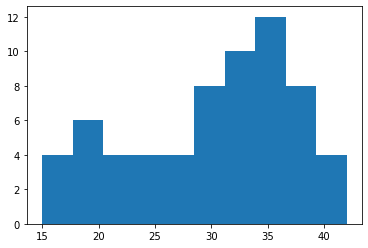

In [7]:
plt.hist(ligand_size_list)

## 3. Lipinski's rule of five

In [42]:
def _n_ligand_fulfilled_criteria(path_json, criteria):

    # get object generator from json
    f = open(path_json, 'rb')
    objects = ijson.items(f, 'item')

    # filter objects
    objects_filtered = (o for o in objects if o[criteria] == 1)
    
    return len(list(objects_filtered))


def _n_ligand_fulfilled_lipinski(path_json):

    # get object generator from json
    f = open(path_json, 'rb')
    objects = ijson.items(f, 'item')
        
    # filter objects
    objects_filtered = (o for o in objects if o['hba']+o['hbd']+o['mwt']+o['logp'] >= 3)

    return len(list(objects_filtered))

def get_ro5_combinatorial_library(path_combinatorial_library, ratio=True):
    
    # Get number of ligands
    f = open(path_combinatorial_library, 'rb')
    objects = ijson.items(f, 'item')
    n_ligands = len(list((o for o in objects)))
    
    # Get Lipinski's rule of five criteria
    ro5_comb = pd.Series(
        {
            'mw': _n_ligand_fulfilled_criteria(path_combinatorial_library, 'mwt'),
            'logp': _n_ligand_fulfilled_criteria(path_combinatorial_library, 'logp'), 
            'hbd': _n_ligand_fulfilled_criteria(path_combinatorial_library, 'hbd'),
            'hba': _n_ligand_fulfilled_criteria(path_combinatorial_library, 'hba'),
            'lipinski': _n_ligand_fulfilled_lipinski(path_combinatorial_library)
        }
    )
    
    if ratio:
        # Get ratio
        ro5_comb = round(ro5_comb / n_ligands * 100, 0)
        ro5_comb = ro5_comb.astype('int')
    
    return ro5_comb

### Recombined ligands

In [43]:
ro5_comb = get_ro5_combinatorial_library(PATH_COMBINATORIAL_LIBRARY)
ro5_comb

mw           78
logp        100
hbd         100
hba          94
lipinski     94
dtype: int64

### PKIDB ligands

PKIDB ligands: approved and investigorial kinase inhibitors

In [10]:
data_pkidb = pd.read_csv('https://raw.githubusercontent.com/dominiquesydow/pkidb_klifs/master/results/pkidb_20200218.csv', index_col=0)
print(f'Number of ligands in PKIDB data: {data_pkidb.shape[0]}')

Number of ligands in PKIDB data: 218


In [11]:
data_pkidb.head(2)

,INN_Name,BrandName,Phase,Applicants,LigID,pdbID,Type,RoF,MW,LogP,...,Targets,Kinase_families,First_Approval,SC_Patent,Chirality,Synonyms,FDA_approved,Melting_points_C,Canonical_Smiles,InChIKey
0,Leniolisib,NaN,0.0,Novartis,9NQ,['5o83'],NaN,0,450.2,2.9,...,NaN,NaN,NaN,NaN,Single Stereoisomer,"['CDZ173-NX', 'Leniolisib']",NaN,NaN,CCC(=O)N1CC[C@@H](C1)Nc2c3c(ncn2)CCN(C3)c4cc(c...,MWKYMZXCGYXLPL-ZDUSSCGKSA-N
1,Nemiralisib,NaN,0.0,GlaxosmithKline,VVX,['5ae8'],NaN,0,440.2,4.9,...,NaN,NaN,NaN,NaN,Single Stereoisomer,"['GSK2269557A', 'GSK-2269557', 'Nemiralisib']",NaN,NaN,CC(C)N1CCN(CC1)Cc2cnc(o2)c3cc(cc4c3cn[nH]4)c5c...,MCIDWGZGWVSZMK-UHFFFAOYSA-N


In [46]:
ro5_pkidb = round(
    data_pkidb.Canonical_Smiles.apply(
        Chem.MolFromSmiles
    ).apply(get_ro5_from_mol).sum() / data_pkidb.shape[0] * 100, 
    0
)
ro5_pkidb = ro5_pkidb.astype('int')
ro5_pkidb

mw           70
logp         74
hbd         100
hba          99
lipinski     85
dtype: int64

### Original ligands

In [13]:
data_klifs= pd.read_csv('../data/fragment_library/original_ligands.csv', index_col=0)
print(f'Number of original KLIFS ligands: {data_klifs.shape[0]}')

Number of original KLIFS ligands: 2553


In [14]:
data_klifs.head(2)

,ligand_pdb,subpocket,kinase,family,group,alt,chain,ac_helix,smiles
complex_pdb,,,,,,,,,
1a9u,SB2,"['AP', 'GA', 'B2']",p38a,MAPK,CMGC,,A,out-like,C[S@](=O)c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)...
1agw,SU2,"['AP', 'SE']",FGFR1,FGFR,TK,B,B,out-like,O=CN1CCN(c2ccc(C[C@@H]3C(=O)Nc4ccccc43)cc2)CC1


In [48]:
ro5_klifs = round(
    data_klifs.smiles.apply(
        Chem.MolFromSmiles
    ).apply(get_ro5_from_mol).sum() / data_klifs.shape[0] * 100, 
    0
)
ro5_klifs = ro5_klifs.astype('int')
ro5_klifs

mw          88
logp        94
hbd         99
hba         99
lipinski    97
dtype: int64

### Plot properties

In [49]:
# Collect data in one DataFrame
bar_data = pd.DataFrame(
    {
        'Recombined ligands': ro5_comb, 
        'Original ligands (KLIFS)': ro5_klifs, 
        'PKIDB ligands': ro5_pkidb
    }
)
bar_data = bar_data.astype('int32')
bar_data

,Recombined ligands,Original ligands (KLIFS),PKIDB ligands
mw,78,88,70
logp,100,94,74
hbd,100,99,100
hba,94,99,99
lipinski,94,97,85


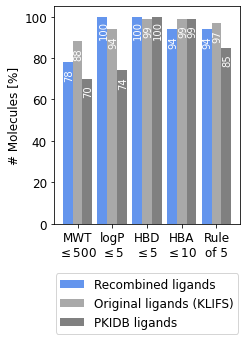

In [50]:
# Plot data
ax = bar_data.plot(
    kind='bar',
    width=0.85,
    rot=0,
    figsize=(3.33, 4),
    color=['cornflowerblue', 'darkgrey', 'grey']
)

# Edit labels for y axis and x/y ticks
plt.ylabel('# Molecules [%]', fontsize=12)
plt.xticks(range(5), ['MWT\n'+r'$\leq 500$', 'logP\n'+r'$\leq 5$', 'HBD\n'+r'$\leq 5$', 'HBA\n'+r'$\leq 10$', 'Rule\nof 5'], fontsize=12)
plt.yticks(fontsize=12)
#plt.legend(fontsize=12, loc='upper left')
legend = plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5,-.2),
           fontsize=12
          )

# Add percentages to bars
bars = ax.patches
bar_labels = bar_data.transpose().values.flatten()
for bar, label in zip(bars, bar_labels):
    
    plt.text(
        bar.get_x() + bar.get_width() / 1.6, 
        bar.get_height() - 6,
        label, 
        ha='center', 
        va='center', 
        fontsize=10,
        color='white',
        rotation=90
    )

In [51]:
ax.get_figure().savefig(
    'figures/combinatorial_library_ro5.pdf',
    bbox_extra_artists=(legend,),
    bbox_inches='tight'
)